<a href="https://colab.research.google.com/github/charliesire/training_ciroquo_transposition/blob/main/run_all_strategies_taylor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pymcmcstat

In [2]:
#!git clone https://github.com/charliesire/training_ciroquo_transposition.git


# This notebook runs all the different strategies

Several design $\mathbb{X} = (\mathbf{x}_j)_{j=1}^n$ are investigated to ensure robustness. Each one is associated with a "seed_x", which is the random seed used to generate the design. For every design, a csv file called "results_measures_seed_x{seed_x}.csv" is stored, with the 10 first rows corresponding to the true values of the outputs and the 10 others to the noisy observations, obtained with sigma = 0.9 for the two first output variables and 0.3 for the last one.

In [3]:
import numpy                as np
import pandas as pd
import pickle
%cd training_ciroquo_transposition
from investigate_alphamap import func_alphamap,check_repeat
from bayes_alpha import *
from bayes_lambda import *
from full_bayes import *
from mm_taylor import *
from utils_plot_errors import *
import seaborn              as sns


/content/training_ciroquo_transposition


In [4]:
if(os.path.isdir("taylor_impact")==False):
    os.mkdir("taylor_impact")

In [5]:
sigma = [0.9,0.9,0.3] #Standard deviation of the observation noise for each output variable
bMINlambda = np.array([330, 70,  8000, 3000, 0.1, 0.1]) #lower bounds for lambda
bMAXlambda = np.array([470, 150, 10000, 5000, 5, 5.0]) #upper bounds for lambda

results_measures = pd.read_csv(f"measures_and_true_values.csv", index_col=0)
true_values = results_measures.iloc[:10,3:] #get true values
results_measures = results_measures.iloc[10:,3:] #get noisy observations

with open(f'mm_list.pkl', 'rb') as f: #get the GP hyperparameters
    mm_list = pickle.load(f)

calib_only = [2] #index of the calibration problems to consider. [1,2,3] means that the three configurations will be tested: observations of the first variable, of the second one, or of the third one.
std_code = True
loo = False

nb_outputs = 3

# Hierarchical model

In [6]:
index_lambda_p = [2,3,4,5] #indexes of the four physical parameters
index_lambda_q = [0,1] #indexes of the two numerical parameters
model_error = True #Model error is  considered, so hierarchical bayesian model for the two numerical parameters
scale = 0.45 #std deviation of the truncated gaussian prior
pre_path = "taylor_impact/hierarchical_model" #where to store the results


## First we estimate alpha_map

In [7]:
M = 1000 #Initial number of i.i.d realizations
iter_lim = 10#Maximum number of iterations
threshold = 0.02

alpha_min = -6 #lower bound for alpha
alpha_max = 6 #upper bound for alpha
delta_alpha = 4 #maximum half width of the interval investigated. The interval will be [max(alpha_min, alpha_star - delta_alpha), min(alpha_max, alpha_star + delta_alpha)]

[func_alphamap(index_calib = index_calib, M = M, iter_lim = iter_lim, threshold = threshold, alpha_min = alpha_min, alpha_max = alpha_max, delta_alpha = delta_alpha, scale = scale, results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], myCODE = myCODE, mm_list = mm_list, index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, bMINlambda= bMINlambda, bMAXlambda = bMAXlambda, pre_path = pre_path, loo = loo, std_code = std_code) for index_calib in calib_only]

IDX LOO  None


[None]

## Then we generate posterior samples $(A_i)_{i=1}^N \propto p(yobs \mid \alpha)p_A(\alpha)$

In [8]:
tune_size = 300
size = 300
rngseed = 10
num_chain = 1
M = 1000

alpha_min = -10 #lower bound for alpha
alpha_max = 10 #upper bound for alpha
delta_alpha = 4 #maximum half width of the interval investigated. The interval will be [max(alpha_min, alpha_star - delta_alpha), min(alpha_max, alpha_star + delta_alpha)]

samples_alpha = [MCMC_alpha_multichains(index_calib=index_calib, scale=scale, num_chain = num_chain, tune_size=tune_size, size=size, M = M,  alpha_min = alpha_min, alpha_max = alpha_max, delta_alpha = delta_alpha, rngseed=rngseed, results_measures= results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], myCODE = myCODE, mm_list = mm_list, index_lambda_p=index_lambda_p, index_lambda_q=index_lambda_q, bMINlambda=bMINlambda, bMAXlambda=bMAXlambda, pre_path = pre_path, loo = loo, std_code = std_code) for index_calib in calib_only]

None
 [-----------------100%-----------------] 600 of 600 complete in 6.2 sec

## Then we generate posterior samples $(\Lambda_k)_{k=1}^M \propto p(yobs \mid \lambda)p_\Lambda(\lambda\mid \alpha_{MAP})$

In [9]:
pre_path = "taylor_impact/hierarchical_model" #where to store the results

tune_size = 2000
size = 750
num_chain = 1
rngseed=1234
#MCMC_multichains generates the posterior samples
[MCMC_lambda_multichains(index_calib = index_calib, model_error = model_error, scale = scale, num_chain = num_chain, tune_size = tune_size, size = size, myCODE = myCODE, mm_list = mm_list,  results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, bMINlambda = bMINlambda, bMAXlambda = bMAXlambda, rngseed = rngseed, pre_path = pre_path, nb_outputs = nb_outputs, loo = loo, std_code = std_code) for index_calib in calib_only]

#bayes_lambda_results computes the performance metrics associated with this sample (with plug-in alpha)
[bayes_lambda_results(index_calib = index_calib, pre_path = pre_path, true_values = true_values, std_code = std_code) for index_calib in calib_only]

 [-----------------100%-----------------] 2750 of 2750 complete in 17.0 sec

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[None]

Finally, we compute the estimator o
$$E_{N,M}(h(\Lambda)) = \frac{1}{N}\sum_{i=1}^N \frac{\sum_{k=1}^M h(\Lambda_k) \frac{p_{\boldsymbol{\Lambda}}(\boldsymbol{\Lambda}_k \mid \boldsymbol{\boldsymbol{A_i}})}{p_{\boldsymbol{\Lambda}}(\boldsymbol{\Lambda}_k \mid \boldsymbol{\boldsymbol{\alpha}^\star})}}{\sum_{k=1}^M  \frac{p_{\boldsymbol{\Lambda}}(\boldsymbol{\Lambda}_k \mid \boldsymbol{\boldsymbol{A_i}})}{p_{\boldsymbol{\Lambda}}(\boldsymbol{\Lambda}_k \mid \boldsymbol{\boldsymbol{\alpha}^\star})}}$$

In [10]:
[full_bayes_results(index_calib = index_calib, index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, scale = scale, bMINlambda = bMINlambda, bMAXlambda = bMAXlambda,pre_path = pre_path, true_values = true_values,loo = loo, std_code = std_code) for index_calib in calib_only]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[None]

# Uniform prior

In [11]:
index_lambda_p = [2,3,4,5,0,1] #here, all variables are considered with uniform prior
index_lambda_q = [] #no hierarchical model
model_error = True
scale = None
pre_path = "taylor_impact/uniform_error" #where to store the results

## We generate posterior samples $(\Lambda_k)_{k=1}^M \propto p(yobs \mid \lambda)p_\Lambda(\lambda)$

In [12]:
#MCMC_multichains generates the posterior samples
[MCMC_lambda_multichains(index_calib = index_calib, model_error = model_error, scale = scale, num_chain = num_chain, tune_size = tune_size, size = size, myCODE = myCODE, mm_list = mm_list,  results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, bMINlambda = bMINlambda, bMAXlambda = bMAXlambda, rngseed = rngseed, pre_path = pre_path, nb_outputs = nb_outputs, loo = loo, std_code = std_code) for index_calib in calib_only]

#bayes_lambda_results computes the performance metrics associated with this sample (with plug-in alpha)
[bayes_lambda_results(index_calib = index_calib, pre_path = pre_path, true_values = true_values, std_code = std_code) for index_calib in calib_only]

 [-----------------100%-----------------] 2750 of 2750 complete in 15.0 sec

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[None]

# No model error

In [13]:
index_lambda_p = [2,3,4,5] #indexes of the four physical parameters
index_lambda_q = [0,1] #indexes of the two numerical parameters
model_error = False #No model error is considered, so the two numerical parameters are fixed
scale = None
pre_path = "taylor_impact/no_error"

## We generate posterior samples $(\Lambda_k)_{k=1}^M \propto p(yobs \mid \lambda)p_\Lambda(\lambda)$

In [14]:
#MCMC_multichains generates the posterior samples
[MCMC_lambda_multichains(index_calib = index_calib, model_error = model_error, scale = scale, num_chain = num_chain, tune_size = tune_size, size = size, myCODE = myCODE, mm_list = mm_list,  results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, bMINlambda = bMINlambda, bMAXlambda = bMAXlambda, rngseed = rngseed, pre_path = pre_path, nb_outputs = nb_outputs, loo = loo, std_code = std_code) for index_calib in calib_only]

#bayes_lambda_results computes the performance metrics associated with this sample (with plug-in alpha)
[bayes_lambda_results(index_calib = index_calib, pre_path = pre_path, true_values = true_values, std_code = std_code) for index_calib in calib_only]

 [-----------------100%-----------------] 2750 of 2750 complete in 21.7 sec

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[None]

# Then, plot the results


In [15]:
pre_path = "taylor_impact/"
variable_names = [r"$\ell_{F} - \ell_{0}$", r"$r_{F}$", r"$\epsilon_{max}$"] #names of the three outputs

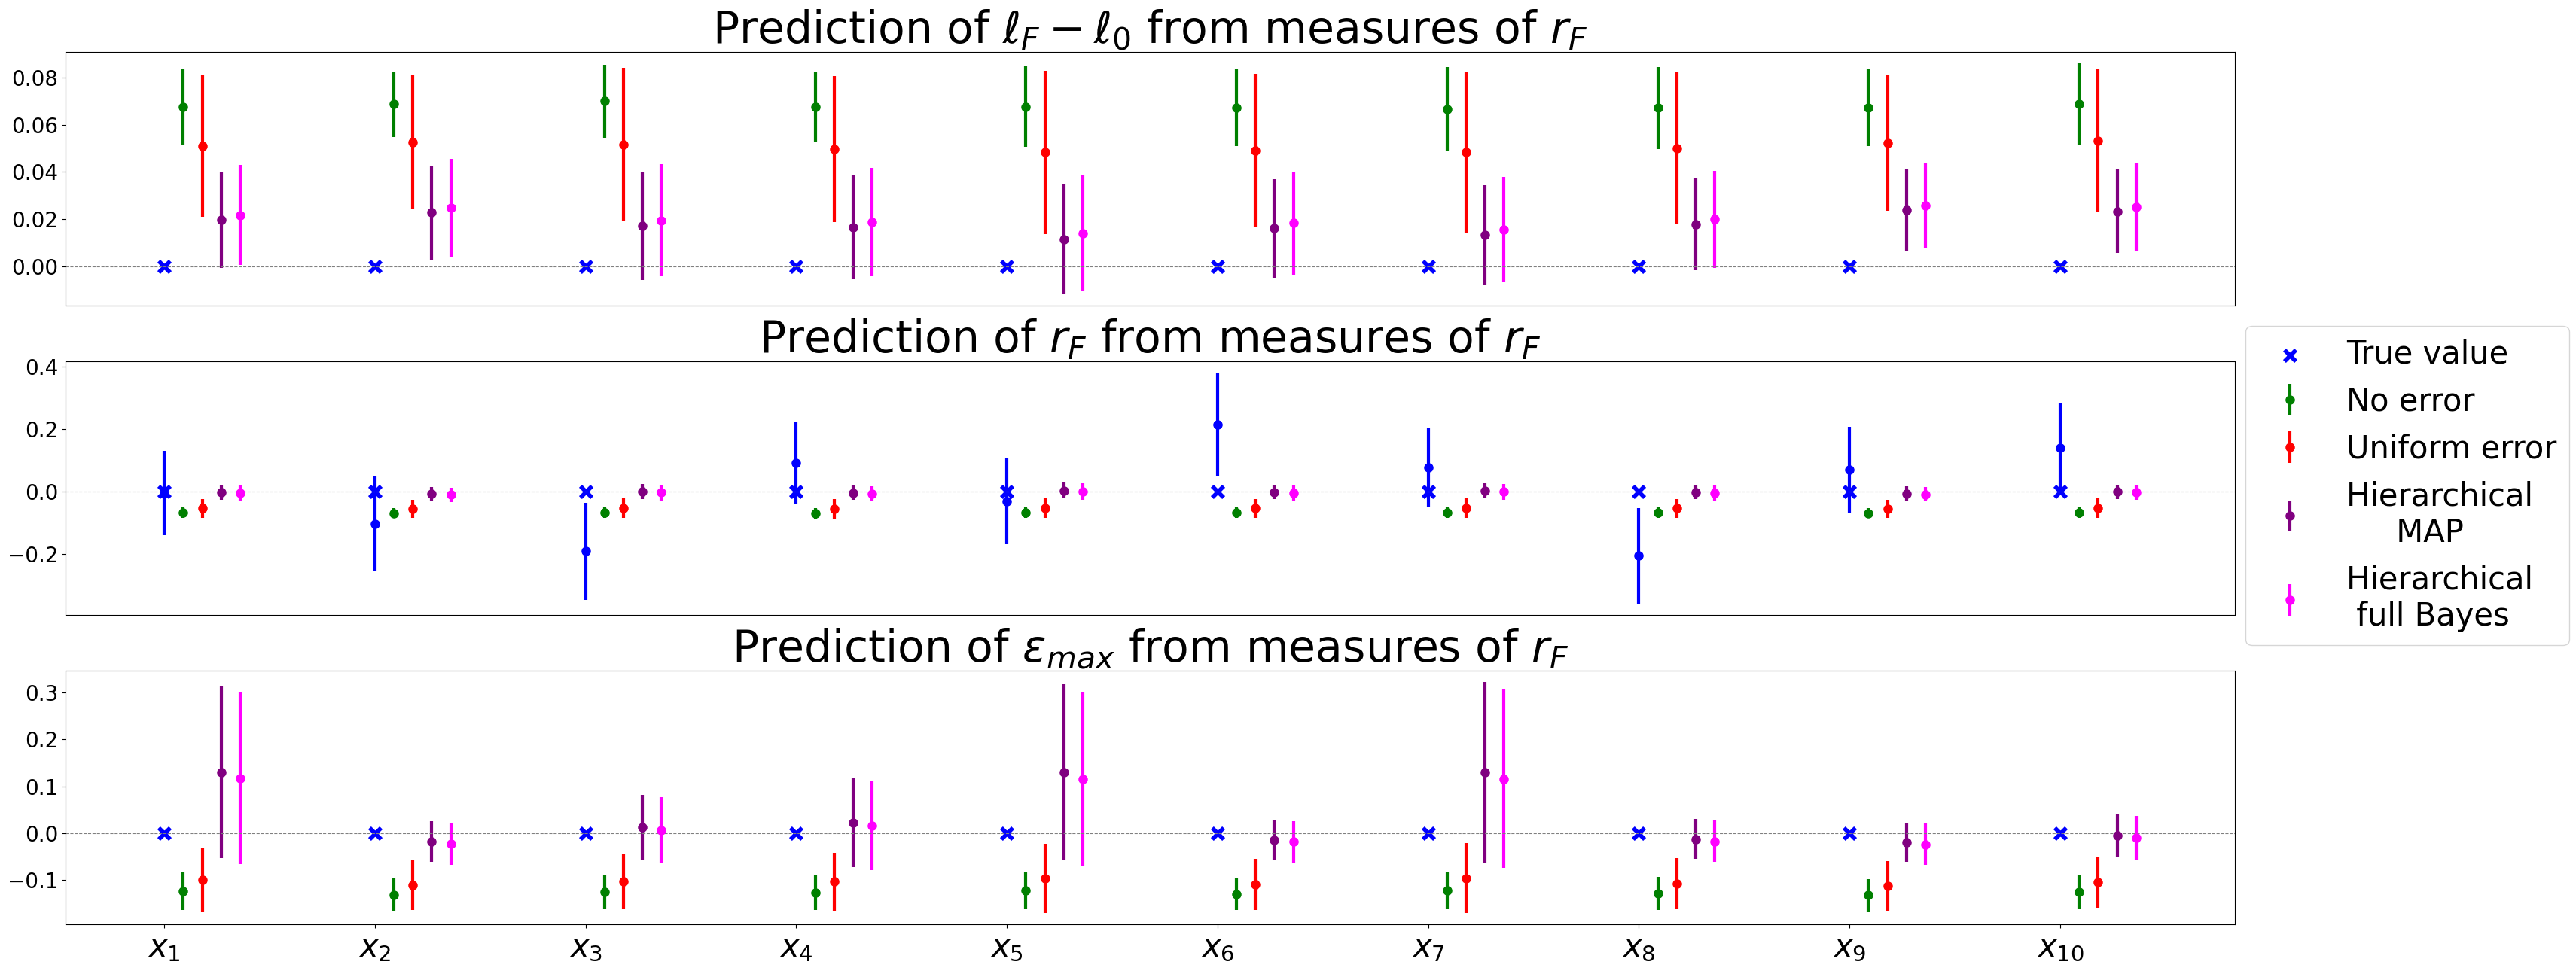

[None]

In [20]:
[plot_mean_std(index_calib = index_calib, results_measures = results_measures, true_values = true_values, sigma = sigma, pre_path = pre_path, variable_names = variable_names, no_error = True, unif_error = True, hierarchical_map = True, full_bayes = True, savefig = True) for index_calib in calib_only]


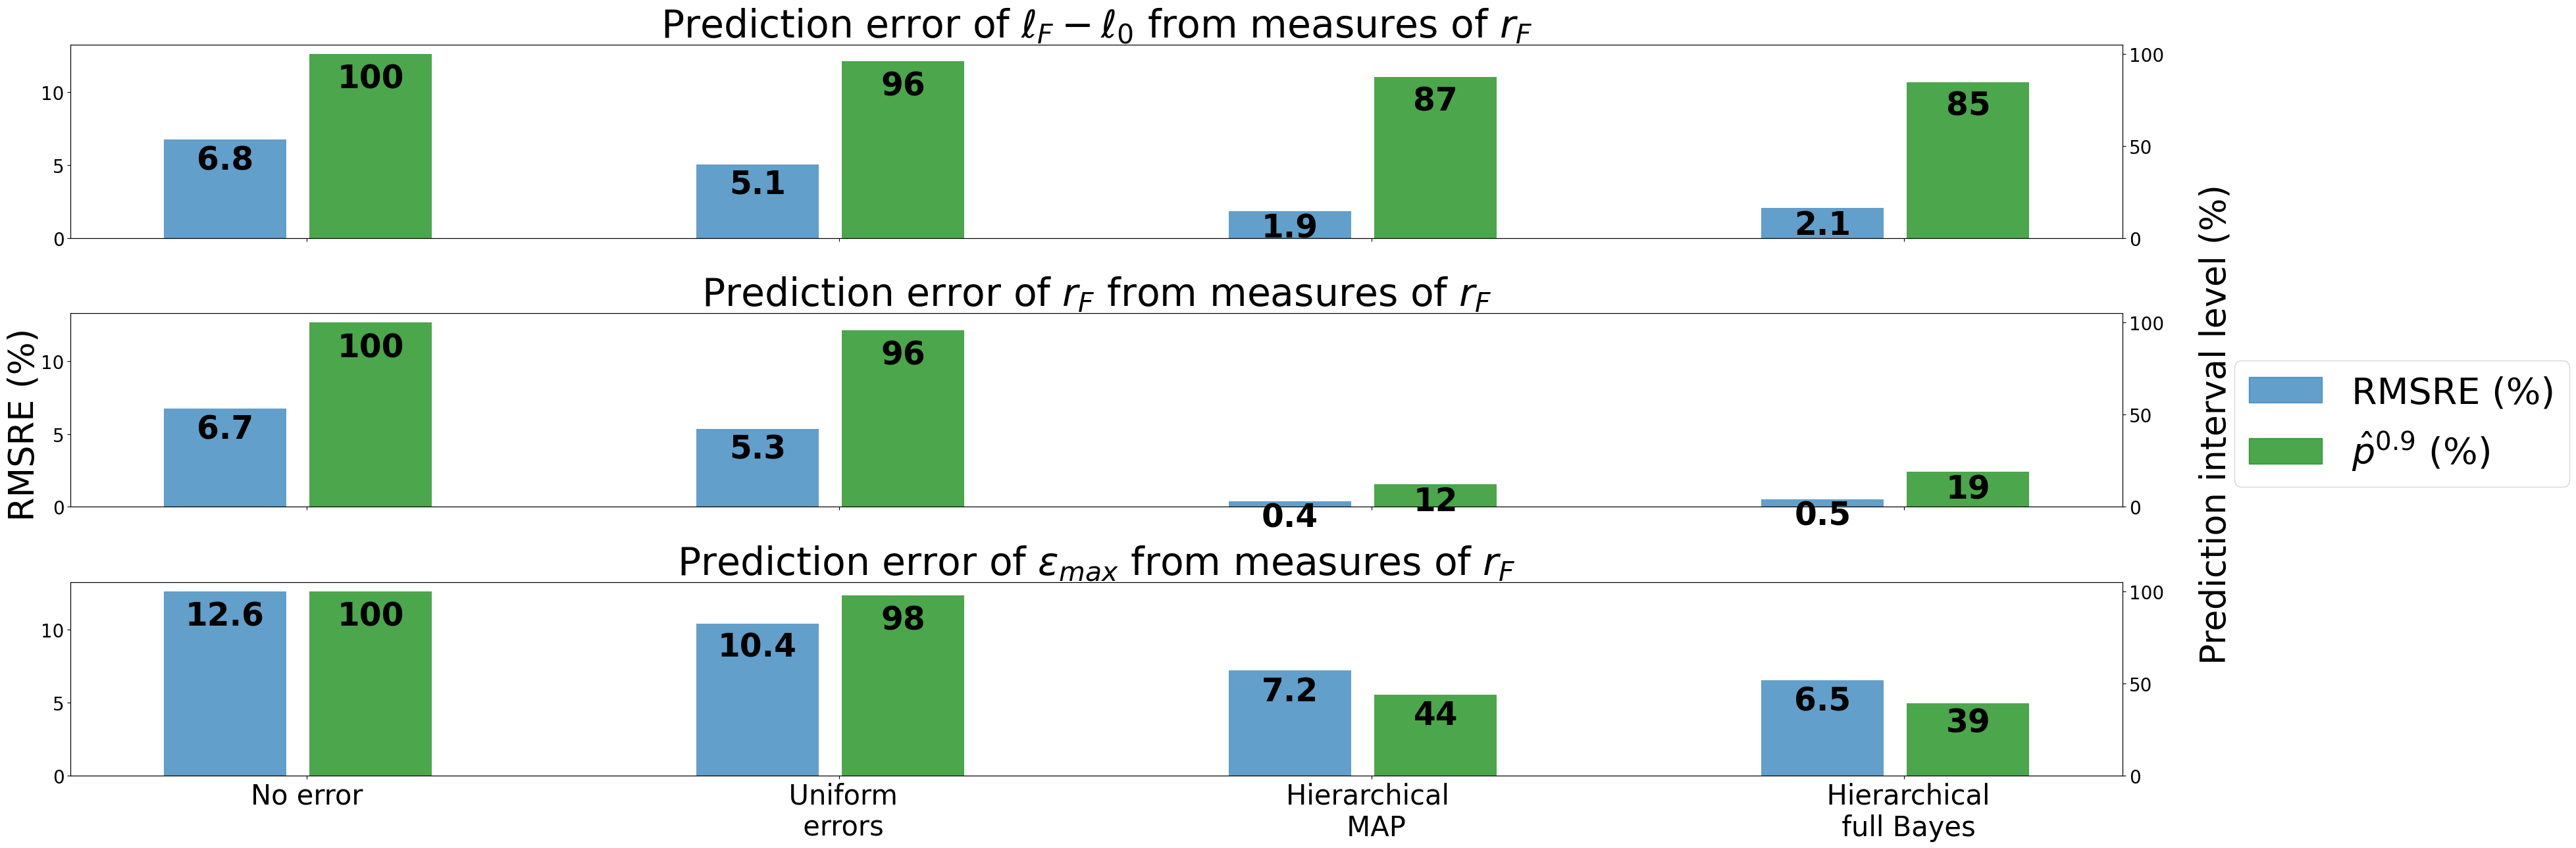

[None]

In [22]:
[plot_errors(index_calib = index_calib, pre_path = pre_path, variable_names = variable_names, no_error = True, unif_error = True, hierarchical_map = True, full_bayes = True, savefig = True, nb_outputs = nb_outputs) for index_calib in calib_only]

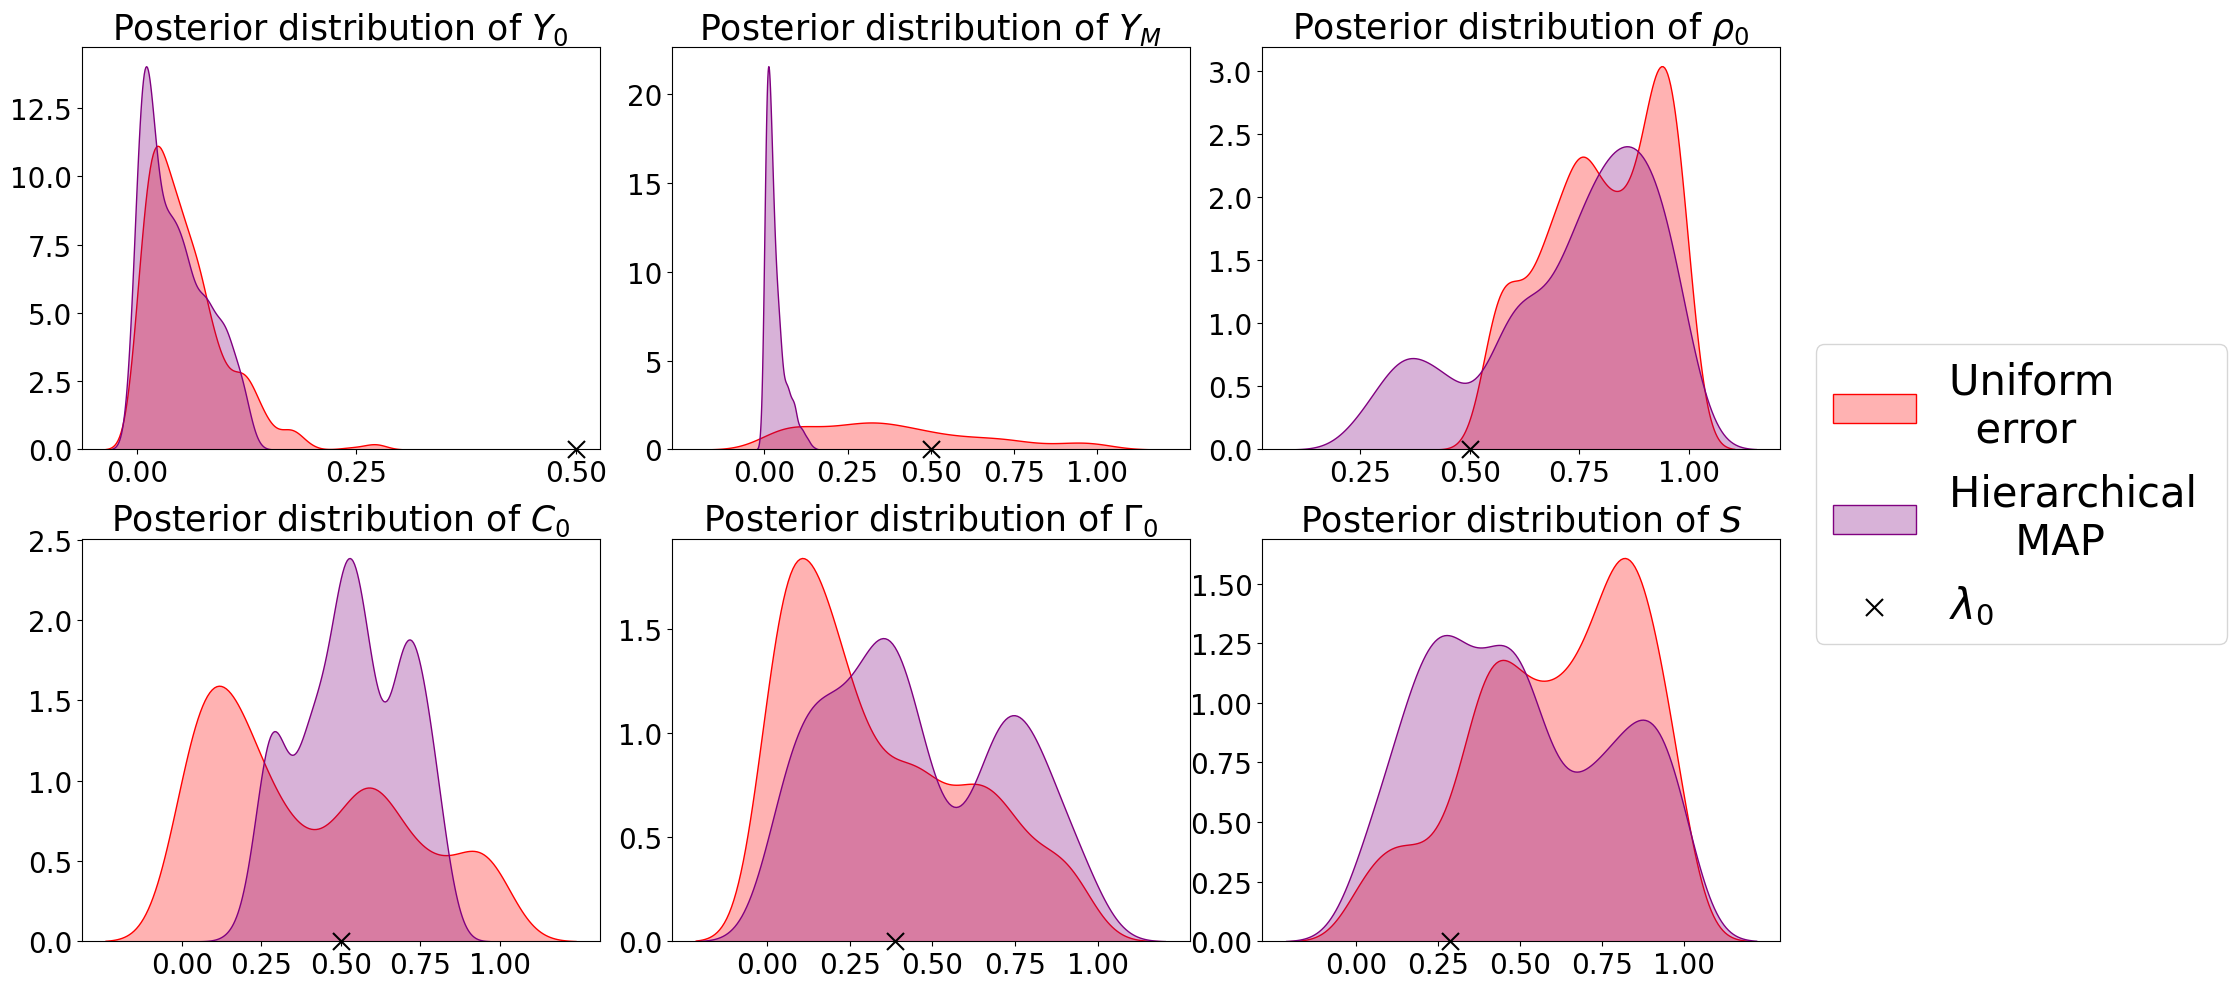

In [18]:
params = [r'$Y_0$', r'$Y_M$',r'$\rho_0$', r'$C_0$', r'$\Gamma_0$', r'$S$'] #variable names

lambda_0 = (np.array([400,110,9000,4000,2,1.5])-bMINlambda)/(bMAXlambda-bMINlambda) #lambda0 used for the measures

index_calib=1 #which calibration variable
idx_loo = 9 #which observation point x_j

sample_unif = pd.read_csv(pre_path + f"uniform_error/calib_{index_calib}/lambd_post.csv", index_col = 0).values #uniform error sample
sample_hier = pd.read_csv(pre_path + f"hierarchical_model/calib_{index_calib}/lambd_post.csv", index_col = 0).values #hierarchical model sample
sample_unif = np.apply_along_axis(lambda x:(x-bMINlambda)/(bMAXlambda-bMINlambda), 1, sample_unif) #normalized sample
sample_hier = np.apply_along_axis(lambda x:(x-bMINlambda)/(bMAXlambda-bMINlambda), 1, sample_hier) #normalized sample

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Tracer les KDE pour chaque colonne
for i in range(6):
    kde_unif = sns.kdeplot(sample_unif[:, i], ax=axes[i], label='Uniform \n  error', color='red', fill=True, alpha=0.3)
    kde_hier = sns.kdeplot(sample_hier[:, i], ax=axes[i], label='Hierarchical \n     MAP', color='purple', fill=True, alpha=0.3)

    axes[i].set_xticks([0, 0.25, 0.5, 0.75, 1])
    axes[i].set_title(f'Posterior distribution of {params[i]}', fontsize=25)
    axes[i].tick_params(axis='both', labelsize=20)
    axes[i].set_ylabel('')  # Supprimer le titre de l'axe Y
    axes[i].scatter(lambda_0[i], 0, color='black', marker='x', s=150, label=r'$\lambda_0$',clip_on=False)

# Créer une légende globale
handles, labels = axes[3].get_legend_handles_labels()  # Récupérer les objets courbes et les labels d'un subplot

# Ajouter la légende globale à droite
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=30)

# Ajuster l'espacement des subplots
plt.tight_layout()

plt.savefig(pre_path + f"plots/compare_samples.jpg",bbox_inches='tight', format = "jpg")

# Afficher la figure
plt.show()